In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
raw = pd.read_csv("Data/student-por.csv", sep = ";")

In [3]:
def onehot_encode(data, var):
    encode = pd.get_dummies(raw[var])
    for label in raw[var].unique():
        data[f'{var}_{label}'] = encode[label]
    data.drop(var, axis = 1, inplace = True)

In [4]:
# onehot encode
data = raw.copy()
for var in raw.columns:
    if type(raw[var][0]) == str:
        onehot_encode(data, var)

In [5]:
data.head()
# 59 columns

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,activities_no,activities_yes,nursery_yes,nursery_no,higher_yes,higher_no,internet_no,internet_yes,romantic_no,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,...,1,0,1,0,1,0,1,0,1,0
1,17,1,1,1,2,0,5,3,3,1,...,1,0,0,1,1,0,0,1,1,0
2,15,1,1,1,2,0,4,3,2,2,...,1,0,1,0,1,0,0,1,1,0
3,15,4,2,1,3,0,3,2,2,1,...,0,1,1,0,1,0,0,1,0,1
4,16,3,3,1,2,0,4,3,2,1,...,1,0,1,0,1,0,1,0,1,0


# Feature Selection - Feature Importance with Trees

A drops G1 and G2\
B all variables

In [6]:
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_validate
from sklearn.ensemble import ExtraTreesClassifier

In [7]:
y = data['G3']
X_A = data.drop(['G3','G1','G2'], axis = 1)  
X_B = data.drop(['G3'], axis = 1)

In [8]:
def feature_select(X, y, max_features = None, threshold = None):
    selection = SelectFromModel(ExtraTreesClassifier(n_estimators = 200), max_features = max_features, threshold = threshold)
    selection.fit(X, y)
    selection.get_support()
    
    selected_feat= X.columns[(selection.get_support())]
    #print(len(selected_feat), selected_feat)
    
    X = selection.transform(X)
    return X, selected_feat

def show_selection(X, y, n_selection):
    forest = ExtraTreesClassifier(n_estimators=200,
                              random_state=0)
    forest.fit(X,y)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    
    # Print the feature ranking
    print("Feature ranking:")
    for f in range(n_selection):
        print(f'{f+1}. {X.columns[indices[f]]} ({importances[indices[f]]})')
    plt.figure(figsize=(25,10))
    plt.title("Feature importances with std")
    indices = indices[:n_selection]
    plt.bar(range(n_selection), importances[indices],
            color="r", yerr=std[indices], align="center")
    plt.xticks(range(n_selection), [X.columns[i] for i in indices])
    plt.xlim([-1, n_selection])
    plt.show()

Feature ranking:
1. absences (0.040263260366210724)
2. age (0.03720486906314541)
3. goout (0.03672200805419668)
4. Walc (0.0354756577549865)
5. health (0.034885056044834696)
6. freetime (0.03377209330564933)
7. Fedu (0.03250105358461644)
8. Medu (0.032490088366288576)
9. famrel (0.032149210989945935)
10. studytime (0.030289065125395274)
11. traveltime (0.027843356683933985)
12. Dalc (0.022644433930237014)
13. Fjob_other (0.022483816314940182)
14. reason_course (0.02046166720256732)
15. famsup_no (0.019946313896560562)
16. famsup_yes (0.019580579260400254)
17. Mjob_other (0.019354891624889698)
18. romantic_no (0.019049309673154272)
19. romantic_yes (0.018920820423771814)
20. Fjob_services (0.018858686071363345)
21. failures (0.01879297999467344)
22. guardian_mother (0.01828327220042508)
23. sex_M (0.01777284774967663)


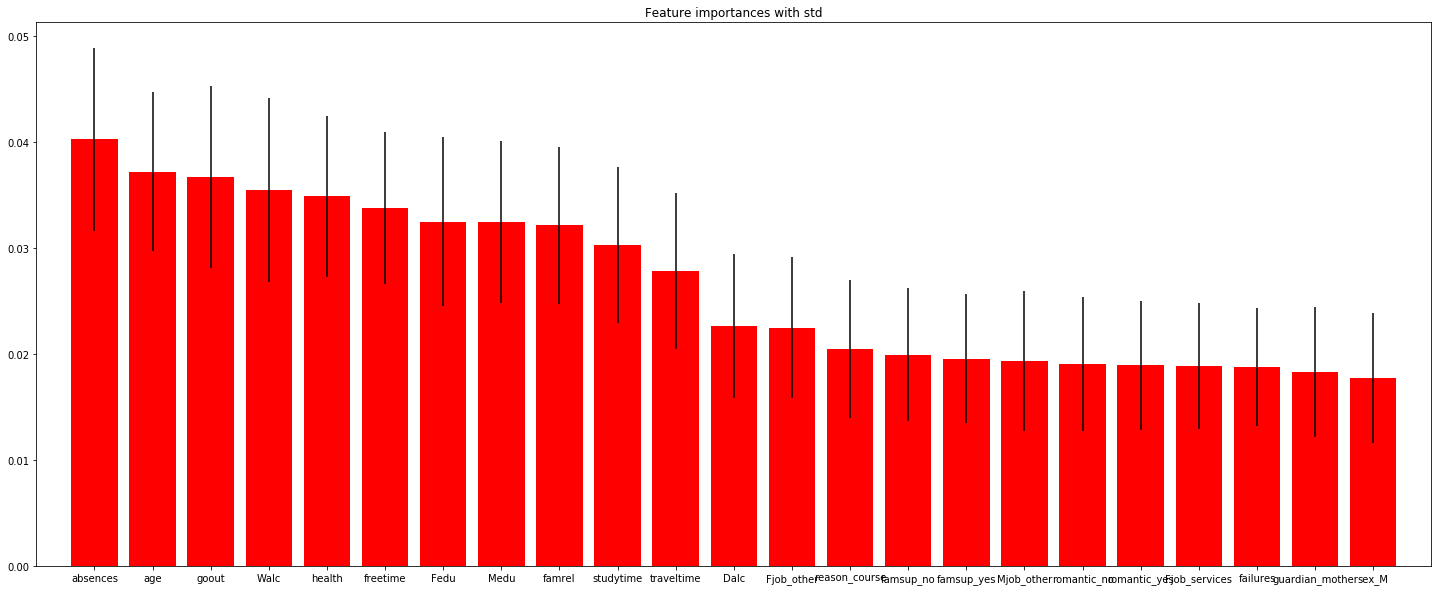

In [9]:
X, selected_feat = feature_select(X_A, y)
show_selection(X_A,y, X.shape[1])

Feature ranking:
1. G2 (0.10541526654765013)
2. G1 (0.07196084986924428)
3. absences (0.029423280711659627)
4. age (0.02822400060431366)
5. goout (0.028184435043281626)
6. Walc (0.027737402519385248)
7. freetime (0.026877026631462405)
8. health (0.026859013616963617)
9. Fedu (0.025584253607456066)
10. Medu (0.025421146105028717)
11. famrel (0.0249625728913108)
12. studytime (0.023348477388105037)
13. traveltime (0.022707301483529254)
14. Dalc (0.018908218270452547)
15. Fjob_other (0.017902975808517352)


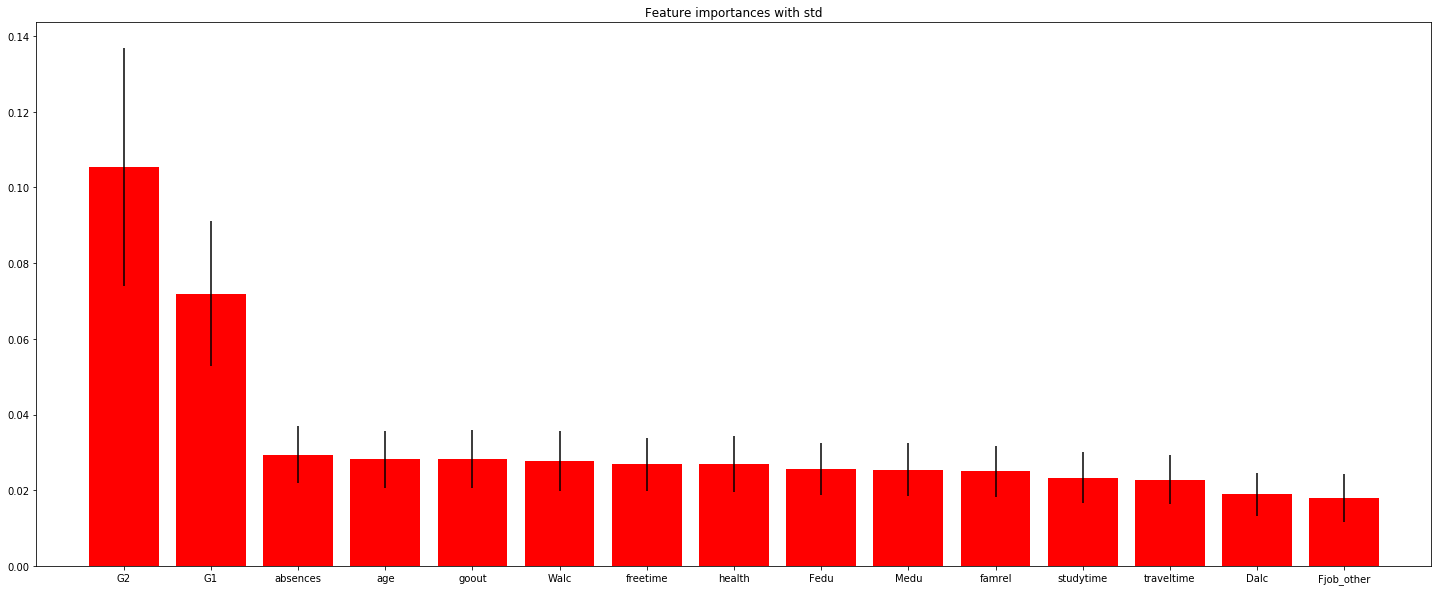

In [10]:
X, selected_feat = feature_select(X_B, y)
show_selection(X_B,y, X.shape[1])

# Model Selection - Regression

## KNRegression

In [11]:
from sklearn.neighbors import KNeighborsRegressor

In [12]:
CV = 10
SCORING = 'neg_mean_squared_error'
def myCV(model, X, y, cv = CV, scoring = SCORING):
    cv_results = cross_validate(model, X, y, cv = cv, scoring = scoring)
    scores = cv_results['test_score']
    
    return np.max(scores), np.min(scores), np.mean(scores), np.median(scores)

def report(_max, _min, mean, median):
    print(f'max: {_max}, min: {_min}')
    print(f'mean: {mean}, median: {median}')
    
def model_select_KNR(krange, X, y, nfolds = CV, scoring = SCORING ):
    lmax, lmin, lmean, lmedian = [], [], [], []
    for k in krange:
        model = KNeighborsRegressor(n_neighbors = k)
        _max, _min, mean, median = myCV(model, X, y, cv=nfolds, scoring = scoring)
        lmax.append(_max)
        lmin.append(_min)
        lmean.append(mean)
        lmedian.append(median)
    return lmax, lmin, lmean, lmedian

def plot(select_function, tune_range, x_label, nfolds = CV, scoring = SCORING):
    fig, ax = plt.subplots(1, 2 ,figsize = (20,5))
    
    X, sel_A = feature_select(X_A, y, threshold = '1.5*mean')
    print(sel_A)
    lmax, lmin, lmean, lmedian = select_function(tune_range, X, y, nfolds = nfolds, scoring = scoring)
    print(f'mean best:[{lmean.index(max(lmean))}], median best:[{lmedian.index(max(lmedian))}]')
    report(max(lmax), max(lmin), max(lmean), max(lmedian))
    ax[0].plot(lmax, label = 'A_max')
    ax[0].plot(lmin,label = 'A_min')
    ax[0].plot(lmean, label = 'A_mean')
    ax[0].plot(lmedian, label = 'A_median')
    ax[0].legend(); ax[0].set_title('Data A after Selection - Negative MSE'); ax[0].set_xlabel(x_label)

    X, sel_B = feature_select(X_B, y, threshold = '1.5*mean')
    print(sel_B)
    lmax, lmin, lmean, lmedian = select_function(tune_range, X, y, nfolds = nfolds, scoring = scoring)
    print(f'mean best:[{lmean.index(max(lmean))}], median best:[{lmedian.index(max(lmedian))}]')
    report(max(lmax), max(lmin), max(lmean), max(lmedian))
    ax[1].plot(lmax, label = 'B_max')
    ax[1].plot(lmin,label = 'B_min')
    ax[1].plot(lmean, label = 'B_mean')
    ax[1].plot(lmedian, label = 'B_median')
    ax[1].legend(); ax[1].set_title('Data B after Selection - Negative MSE'); ax[1].set_xlabel(x_label)

    plt.show()

Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'famrel', 'freetime',
       'goout', 'Walc', 'health', 'absences'],
      dtype='object')
mean best:[30], median best:[23]
max: -3.752615384615385, min: -27.44770144628099
mean: -9.600435697115385, median: -8.253341538461537
Index(['age', 'Fedu', 'freetime', 'goout', 'Walc', 'health', 'absences', 'G1',
       'G2'],
      dtype='object')
mean best:[10], median best:[8]
max: -0.5066751430387795, min: -5.751953125
mean: -2.370669237446581, median: -1.6137692307692308


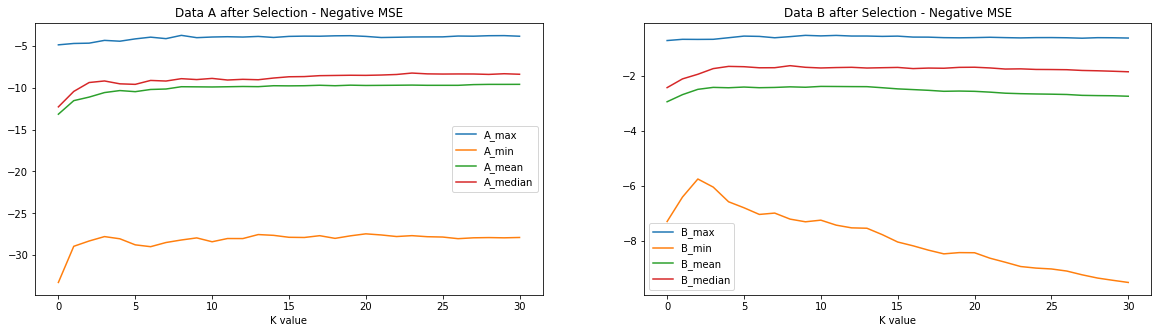

In [13]:
krange = range(2, 33)

plot(model_select_KNR, krange, 'K value')

In [14]:
# best k value = 
best_A = krange[17]; best_B = krange[3]

Xa, sel_A = feature_select(X_A, y, threshold = '1.5*mean'); print(sel_A)
Xb, sel_B = feature_select(X_B, y, threshold = '1.5*mean'); print(sel_B)

result = myCV(KNeighborsRegressor(n_neighbors = best_A), Xa, y)
report(*result)

result = myCV(KNeighborsRegressor(n_neighbors = best_B), Xb, y)
report(*result)

Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'famrel', 'freetime',
       'goout', 'Walc', 'health', 'absences'],
      dtype='object')
Index(['age', 'freetime', 'goout', 'Walc', 'health', 'absences', 'G1', 'G2'], dtype='object')
max: -3.855614745365437, min: -27.668022853185597
mean: -9.710556813339016, median: -8.564180694651608
max: -0.5833846153846154, min: -6.021875
mean: -2.374741346153846, median: -1.8301538461538462


## Decesion Tree

In [15]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

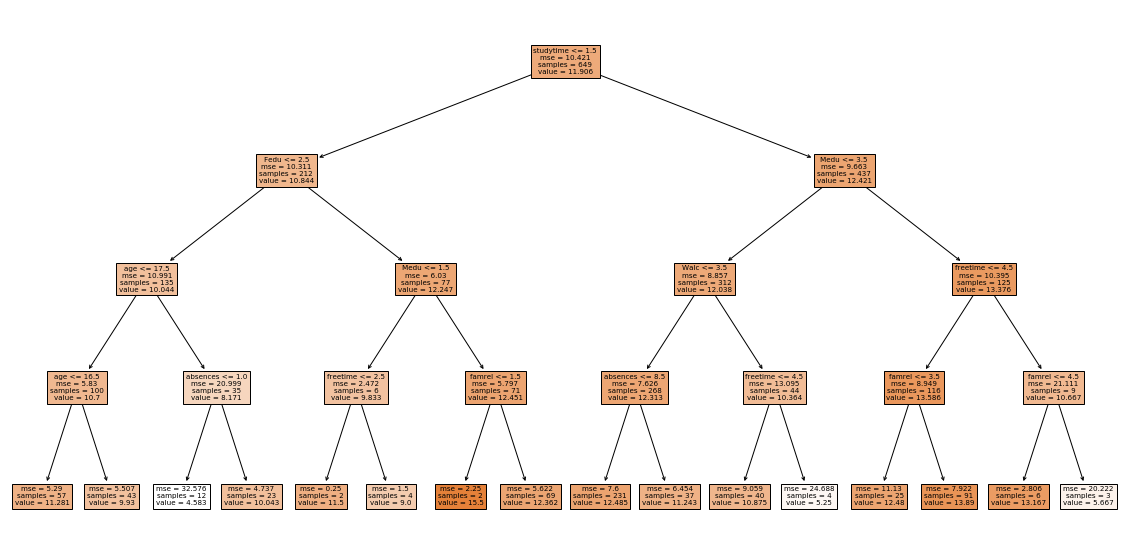

In [16]:
X,selected_feat = feature_select(X_A, y, max_features = 10, threshold = '1.5*mean')

reg_tree = DecisionTreeRegressor(max_depth=4)
reg_tree.fit(X, y)

plt.figure(figsize = (20,10))
tree.plot_tree(reg_tree, filled=True, feature_names = selected_feat, class_names = ['ok','fine'])
plt.show()

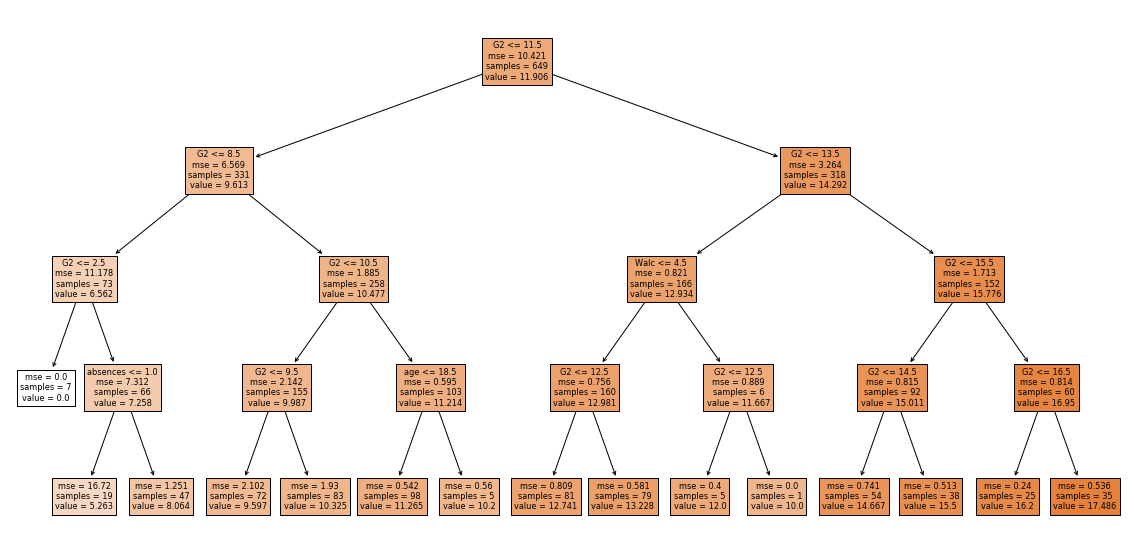

In [17]:
X,selected_feat = feature_select(X_B, y, max_features = 10, threshold = '1.5*mean')

reg_tree = DecisionTreeRegressor(max_depth=4)
reg_tree.fit(X, y)

plt.figure(figsize = (20,10))
tree.plot_tree(reg_tree, filled=True, feature_names = selected_feat)
plt.show()

In [18]:
def model_select_DTR(drange, X, y, nfolds = 5, scoring = 'neg_mean_squared_error' ):
    lmax, lmin, lmean, lmedian = [], [], [], []
    for depth in drange:
        model = DecisionTreeRegressor(max_depth = depth)
        _max, _min, mean, median = myCV(model, X, y, cv=nfolds, scoring = scoring)
        lmax.append(_max)
        lmin.append(_min)
        lmean.append(mean)
        lmedian.append(median)
    return lmax, lmin, lmean, lmedian

Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'famrel', 'freetime',
       'goout', 'Walc', 'health', 'absences'],
      dtype='object')
mean best:[0], median best:[1]
max: -4.123454707125755, min: -28.802459883850684
mean: -10.39156217553696, median: -9.504890778174005
Index(['age', 'Fedu', 'freetime', 'goout', 'Walc', 'health', 'absences', 'G1',
       'G2'],
      dtype='object')
mean best:[2], median best:[3]
max: -0.34191503755849273, min: -5.207631258138006
mean: -1.8352742892484024, median: -1.2370325684826944


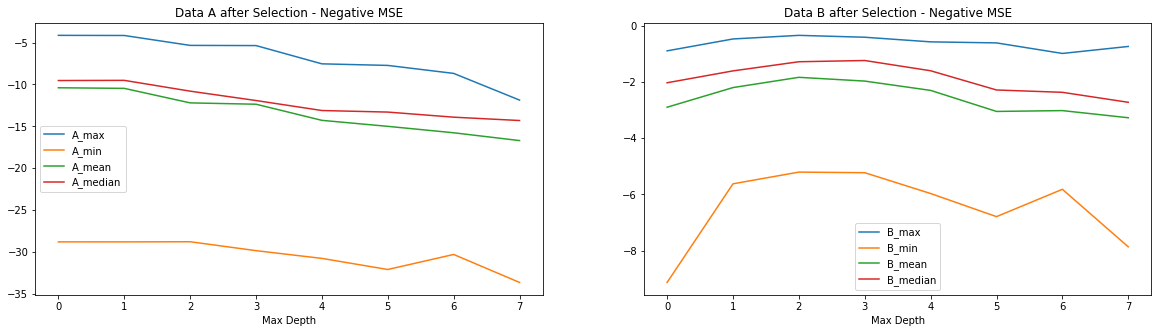

In [19]:
drange = range(2, 10)

plot(model_select_DTR, drange, 'Max Depth')

In [20]:
best_A = drange[0]; best_B = drange[2]

result = myCV(DecisionTreeRegressor(max_depth = best_A), Xa, y)
report(*result)

result = myCV(DecisionTreeRegressor(max_depth = best_B), Xb, y)
report(*result)

max: -4.123454707125755, min: -28.81851365111851
mean: -10.39156217553696, median: -9.52536805979777
max: -0.34191503755849273, min: -5.207631258138006
mean: -1.8280627507868643, median: -1.2809932195550218


# Random Forest

In [21]:
from sklearn.ensemble import RandomForestRegressor

In [22]:
def model_select_RFR(drange, X, y, nfolds = 5, scoring = 'neg_mean_squared_error' ):
    lmax, lmin, lmean, lmedian = [], [], [], []
    for depth in drange:
        model = RandomForestRegressor(max_depth = depth)
        _max, _min, mean, median = myCV(model, X, y, cv=nfolds, scoring = scoring)
        lmax.append(_max)
        lmin.append(_min)
        lmean.append(mean)
        lmedian.append(median)
    return lmax, lmin, lmean, lmedian

Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'famrel', 'freetime',
       'goout', 'Walc', 'health', 'absences'],
      dtype='object')
mean best:[5], median best:[3]
max: -3.9440155570274382, min: -25.492618193906477
mean: -9.585598397718476, median: -8.305648319189457
Index(['age', 'Fedu', 'freetime', 'goout', 'Walc', 'health', 'absences', 'G1',
       'G2'],
      dtype='object')
mean best:[2], median best:[2]
max: -0.28599723857275133, min: -4.842409003301359
mean: -1.739836805049194, median: -1.1998975047078926


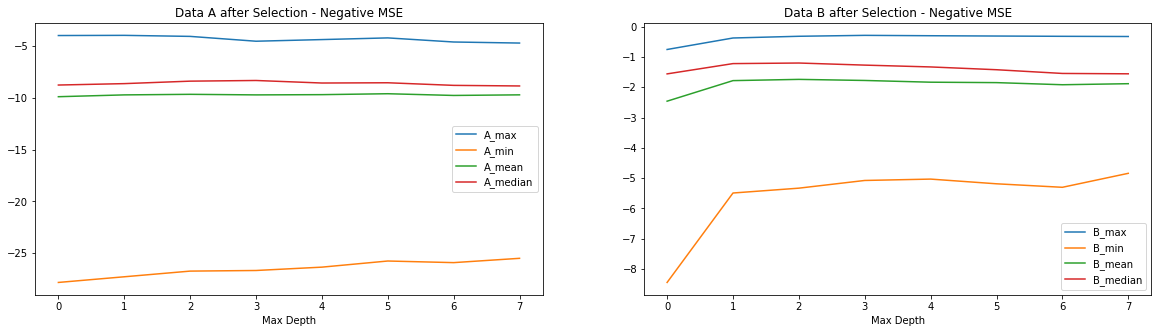

In [23]:
drange = range(2, 10)

plot(model_select_RFR, drange, 'Max Depth')

In [30]:
best_A = drange[5]; best_B = drange[2]

result = myCV(RandomForestRegressor(max_depth = best_A), Xa, y)
report(*result)

result = myCV(RandomForestRegressor(max_depth = best_B), Xb, y)
report(*result)

max: -4.683091016170184, min: -26.07011169770146
mean: -9.772826302196044, median: -8.81882452154332
max: -0.31532870147833614, min: -5.110772854074692
mean: -1.72044137114524, median: -1.2390664792283324


# Gradient Boosting

In [25]:
from sklearn.ensemble import GradientBoostingRegressor

In [26]:
def model_select_Ada(nrange, X, y, nfolds = 5, scoring = 'neg_mean_squared_error' ):
    lmax, lmin, lmean, lmedian = [], [], [], []
    for n in nrange:
        model = GradientBoostingRegressor(n_estimators = n)
        _max, _min, mean, median = myCV(model, X, y, cv=nfolds, scoring = scoring)
        lmax.append(_max)
        lmin.append(_min)
        lmean.append(mean)
        lmedian.append(median)
    return lmax, lmin, lmean, lmedian

Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'famrel', 'freetime',
       'goout', 'Walc', 'health', 'absences'],
      dtype='object')
mean best:[0], median best:[1]
max: -3.9741521816307435, min: -24.59359748816512
mean: -9.827761612582119, median: -8.847512495142311
Index(['age', 'Fedu', 'freetime', 'goout', 'Walc', 'health', 'absences', 'G1',
       'G2'],
      dtype='object')
mean best:[2], median best:[0]
max: -0.3004828937277783, min: -4.769714068792573
mean: -1.7013556443826512, median: -1.2532082056351208


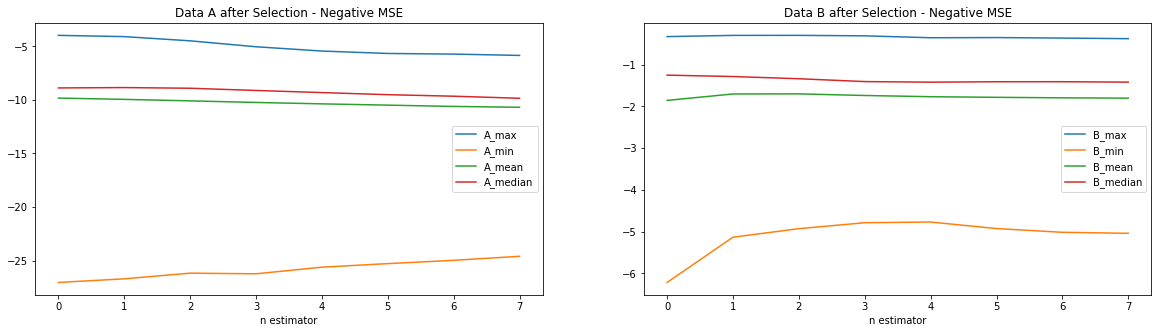

In [27]:
nrange = range(20, 161, 20)
plot(model_select_Ada, nrange, 'n estimator')

In [29]:
best_A = nrange[0]; best_B = nrange[2]

result = myCV(GradientBoostingRegressor(n_estimators = best_A), Xa, y)
report(*result)

result = myCV(GradientBoostingRegressor(n_estimators = best_B), Xb, y)
report(*result)

max: -3.9741521816307435, min: -27.034965678924344
mean: -9.846073650006469, median: -8.876962229794284
max: -0.3073844357870998, min: -4.910267894993822
mean: -1.6931574446639932, median: -1.3550353490909826
